In [2]:
# Authors: Michael Sander, Pierre Ablin
# License: MIT

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms
import os

#from momentumnet.models import ResNet101, mResNet101, ResNet18, mResNet18, mResNet34, ResNet34, mResNet152, ResNet152

from neural_ode.resnet_pytorch import ResNet101, mResNet101, ResNet18, mResNet18, mResNet34, ResNet34, mResNet152, ResNet152

n_workers = 10
n_iters = 220
lr = np.ones(n_iters) * 0.01
lr[180:] /= 10
lr_list = lr
model='resnet101'
mem=True
init_speed=0
cifar100=False
save_adr=None
gamma=0.9
seed=0
save=True

In [11]:
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
is_momnet = model.startswith('m')
# Data
expe_name = 'ckpt_model_%s_seed_%d_gamma_%.2e.pth' % (model, seed, gamma)
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
if cifar100:
    Loader = torchvision.datasets.CIFAR100
    root = '.data/CIFAR100'
else:
    Loader = torchvision.datasets.CIFAR10
    root = '.data/CIFAR10'
trainset = Loader(root=root, train=True, download=True, transform=transform_train)
testset = Loader(root=root, train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=n_workers)

# Model
print('==> Building model..')
if model == 'mresnet18':
    net = mResNet18
if model == 'resnet18':
    net = ResNet18
if model == 'mresnet34':
    net = mResNet34
if model == 'resnet34':
    net = ResNet34
if model == 'mresnet101':
    net = mResNet101
if model == 'resnet101':
    net = ResNet101
if model == 'mresnet152':
    net = mResNet152
if model == 'resnet152':
    net = ResNet152
num_classes = 100 if cifar100 else 10
if not is_momnet:
    net = net(num_classes=num_classes)
else:
    net = net(num_classes=num_classes, mem=mem)
layer_1 = net.layer1[0].to(device)
net = net.to(device)
if device == 'cuda':
    layer_1 =  torch.nn.DataParallel(layer_1).cuda()
    net = torch.nn.DataParallel(net).cuda()
resume = os.path.isdir('checkpoint_CIFAR10_resnet')
if (resume == True):
    assert os.path.isdir('checkpoint_CIFAR10_resnet'), 'Error: no checkpoint directory found!'
    try:
        checkpoint = torch.load('./checkpoint_CIFAR10_resnet/%s' % expe_name)
        net.load_state_dict(checkpoint['net'])
        print('==> Resuming from checkpoint..')
    except:
        pass

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=lr_list[0],
                      momentum=0.9, weight_decay=5e-4)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..


In [235]:
net.layer1

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [109]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [110]:
x = torch.rand(1,3,32,32)

In [111]:
def number_of_params(x):
    return( x.shape[1]*x.shape[2]*x.shape[3])

In [112]:
n = 256 

def print_sizes(net,x):
    mem_cost = count_parameters(net) + number_of_params(x) * n
    for mod, f, depth in zip(['conv1', 'bn1', "relu", "maxpool", "layer1",
              "layer2", "layer3", "layer4", "avgpool"], [net.conv1, net.bn1, net.relu, net.maxpool, net.layer1,
              net.layer2, net.layer3, net.layer4, net.avgpool], [ 1, 1, 1, 1, 3, 4, 23, 3, 1]): 
        x = f(x)
        mem = number_of_params(x) * n * depth
        print(mod, mem * 3.7253e-9)
        print(x.shape)
        mem_cost += mem
    x = x.view(x.size(0), -1)
    x = net.fc(x)
    print(x)
    return (mem_cost)

def print_sizes_gamma(net,x, gamma):
    mem_cost = count_parameters(net)
    for mod, f, depth in zip(['conv1', 'bn1', "relu", "maxpool", "layer1",
              "layer2", "layer3", "layer4", "avgpool"], [net.conv1, net.bn1, net.relu, net.maxpool, net.layer1,
              net.layer2, net.layer3, net.layer4, net.avgpool], [ 1, 1, 1, 1, 3, 4, 23, 3, 1]): 
        x = f(x)
        #print(mod, depth)
        if depth > 1:
            mem = depth * number_of_params(x) * n * np.log(1/gamma) / (np.log(10)) + 2 * number_of_params(x) * n
        else:
            mem = number_of_params(x) * n * depth 
        mem_cost += mem
        #print(mem)
    x = x.view(x.size(0), -1)
    x = net.fc(x)
    return (int(mem_cost))
    
    

In [90]:
n = 1
x = torch.rand(256, 64, 16, 16)
identity = x
t = number_of_params(x) * n 
y = net.layer1[0].conv1(x)
t += number_of_params(y) * n 
y = net.layer1[0].bn1(y)
t += number_of_params(y) * n 
y = net.layer1[0].relu(y)
t += number_of_params(y) * n 
y = net.layer1[0].conv2(y)
t += number_of_params(y) * n 
y = net.layer1[0].bn2(y)
t += number_of_params(y) * n 
y = net.layer1[0].relu(y)
t += number_of_params(y) * n 
y = net.layer1[0].conv3(y)
t += number_of_params(y) * n 
y = net.layer1[0].bn3(y)
t += number_of_params(y) * n 
identity = net.layer1[0].downsample(x)
t += number_of_params(identity) * n 
y += identity
t += number_of_params(y) * n 
y = net.layer1[0].relu(y)
t += number_of_params(y) * n 
t += count_parameters(net.layer1[0])

In [91]:
t * 3.7253e-9

0.4221555259648

In [36]:
print_sizes(net,x)

conv1 0.0625001627648
torch.Size([1, 64, 32, 32])
bn1 0.0625001627648
torch.Size([1, 64, 32, 32])
relu 0.0625001627648
torch.Size([1, 64, 32, 32])
maxpool 0.0156250406912
torch.Size([1, 64, 16, 16])
layer1 0.0625001627648
torch.Size([1, 256, 16, 16])
layer2 0.0312500813824
torch.Size([1, 512, 8, 8])
layer3 0.0156250406912
torch.Size([1, 1024, 4, 4])
layer4 0.0078125203456
torch.Size([1, 2048, 2, 2])
avgpool 0.0019531300864
torch.Size([1, 2048, 1, 1])
tensor([[-4.4013e-01, -1.2174e+00, -7.9049e-04,  4.9259e-01, -7.5808e-01,
          6.6877e-02, -9.0379e-01,  3.1142e-02, -2.3963e-01, -9.0224e-01]],
       grad_fn=<AddmmBackward>)


129806922

In [32]:
print_sizes_gamma(net,x, 1)

160477770

In [113]:
mem_cost_gamma = [print_sizes(net,x)]
gammas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for gamma in gammas[1:]:
    mem_cost_gamma.append(print_sizes_gamma(net,x, gamma))
    

conv1 0.0625001627648
torch.Size([1, 64, 32, 32])
bn1 0.0625001627648
torch.Size([1, 64, 32, 32])
relu 0.0625001627648
torch.Size([1, 64, 32, 32])
maxpool 0.0156250406912
torch.Size([1, 64, 16, 16])
layer1 0.1875004882944
torch.Size([1, 256, 16, 16])
layer2 0.1250003255296
torch.Size([1, 512, 8, 8])
layer3 0.3593759358976
torch.Size([1, 1024, 4, 4])
layer4 0.0234375610368
torch.Size([1, 2048, 2, 2])
avgpool 0.0019531300864
torch.Size([1, 2048, 1, 1])
tensor([[-0.5948, -1.1525, -0.0970,  0.5388, -0.5556,  0.1814, -1.0088,  0.2380,
         -0.1516, -0.7756]], grad_fn=<AddmmBackward>)


In [104]:
np.save('mem_cost_gamma.npy', mem_cost_gamma)

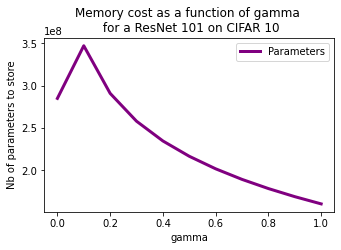

In [114]:
plt.figure(figsize = (5.2,3.2))
plt.plot(gammas, mem_cost_gamma, lw = 3, color = 'purple', label='Parameters')
plt.xlabel('gamma')
plt.ylabel('Nb of parameters to store')
plt.title('Memory cost as a function of gamma \n for a ResNet 101 on CIFAR 10')
plt.legend()
plt.savefig('rebuttal_error.pdf')
plt.show()

In [205]:
x.type()

'torch.FloatTensor'

In [194]:
print_sizes(net,x), print_sizes_gamma(net,x, 0.00001)

(163361354, 227324490)

In [123]:
inputs = trainloader.dataset[0][0].view(1,3,32,32)


In [124]:
optimizer.zero_grad()
print_sizes(net,inputs)
outputs = net(inputs)



393216
conv1 1
8388608
bn1 1
8388608
relu 1
8388608
maxpool 1
2097152
layer1 3
25165824
layer2 4
16777216
layer3 23
48234496
layer4 3
3145728
avgpool 1
262144


In [222]:
x = torch.rand(256, 64, 16, 16)

In [223]:
x.shape

torch.Size([256, 64, 16, 16])

In [227]:
net.layer1(x).shape

torch.Size([256, 256, 16, 16])

In [221]:
epoch =0
torch.cuda.reset_peak_memory_stats(device=device)
#inputs, targets = inputs.to(device), targets.to(device)
inputs = torch.rand(256, 3, 32, 32).to(device)
print(inputs.shape)
optimizer.zero_grad()
outputs = net(inputs)
loss = outputs.sum()**2
loss.backward()
optimizer.step()
used_mem = torch.cuda.max_memory_allocated(device=device) * 9.31323 * 10**(-10)
print(used_mem)
print('done')

   

ValueError: Expected a cuda device, but got: cpu

In [25]:
epoch = 0
torch.cuda.reset_peak_memory_stats(device=device)
for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        used_mem = torch.cuda.max_memory_allocated(device=device) * 9.31323 * 10**(-10)
        print(used_mem)
        print('done')
        break

        print('Epoch %d: %.2e, %.2e' % (epoch, train_loss/(batch_idx+1), 100.*correct/total))
   

torch.Size([128, 3, 32, 32])
torch.Size([128, 64, 32, 32])
torch.Size([128, 64, 32, 32])
torch.Size([128, 64, 32, 32])
torch.Size([128, 64, 16, 16])
torch.Size([128, 256, 16, 16])
torch.Size([128, 512, 8, 8])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd15d25e670>
Traceback (most recent call last):
  File "/Users/sander/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/Users/sander/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/sander/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/sander/opt/anaconda3/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/sander/opt/anaconda3/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/sander/opt/anaconda3/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)


KeyboardInterrupt: 